# Projet : Analyse des Avis et Alertes ANSSI avec Enrichissement des CVE

**Objectifs :**
1. Extraire les bulletins ANSSI (avis et alertes)
2. Identifier les CVE mentionnées
3. Enrichir avec API MITRE et EPSS
4. Consolider dans un DataFrame
5. Analyser et visualiser
6. Générer des alertes

## IMPORTS ET CONFIGURATION

In [43]:
# Imports
import feedparser
import requests
import re
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports OK")

Imports OK


In [44]:
# ============================================================================
# CONFIGURATION
# ============================================================================

USE_LOCAL_DATA = True  # True = données locales, False = API

# Chemins
DATA_DIR = Path("data_pour_TD_final_2026")
ALERTES_DIR = DATA_DIR / "alertes"
AVIS_DIR = DATA_DIR / "avis"
FIRST_DIR = DATA_DIR / "first"
MITRE_DIR = DATA_DIR / "mitre"
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

# URLs
URL_AVIS = "https://www.cert.ssi.gouv.fr/avis/feed"
URL_ALERTE = "https://www.cert.ssi.gouv.fr/alerte/feed"

# Rate limiting
RATE_LIMIT_DELAY = 2

# Pattern CVE
CVE_PATTERN = r"CVE-\d{4}-\d{4,7}"

print(f" Mode: {'LOCAL' if USE_LOCAL_DATA else 'EN LIGNE'}")

 Mode: LOCAL


In [45]:
# Fonction utilitaire
def get_severity(score):
    """Retourne la sévérité selon le score CVSS"""
    if score == "Non renseigné" or score is None:
        return "Non renseigné"
    try:
        score = float(score)
        if score >= 9.0:
            return "Critique"
        elif score >= 7.0:
            return "Elevée"
        elif score >= 4.0:
            return "Moyenne"
        else:
            return "Faible"
    except:
        return "Non renseigné"

## 1️. EXTRACTION DES BULLETINS

In [46]:
def charger_bulletins_local():
    """Charge bulletins depuis fichiers JSON locaux"""
    bulletins = []
    
    print("Chargement local...")
    
    # Alertes
    if ALERTES_DIR.exists():
        alerte_count=0
        for file in ALERTES_DIR.iterdir():
            if file.is_file():
                try:
                    with open(file, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        
                        if "cves" in data and isinstance(data["cves"],list):
                            cves = [cve["name"] for cve in data["cves"] if "name" in cve]
                        else:
                            # Fallback regex
                            cves = list(set(re.findall(CVE_PATTERN, str(data))))
                        
                        date = (data.get("published_at") or 
                               data.get("published") or 
                               data.get("date") or 
                               "Date inconnue")
                        
                        bulletins.append({
                            "titre": data.get("title", "Sans titre"),
                            "type": "Alerte",
                            "date": date,
                            "lien": data.get("link", ""),
                            "cves": cves
                        })

                        alerte_count+=1

                except Exception as e:
                    print(f"{file.name}: {e}")
        print(f"   - {alerte_count} alertes chargées")
    
    # Avis
    if AVIS_DIR.exists():
        avis_count=0
        for file in AVIS_DIR.iterdir():
            if file.is_file():
                try:
                    with open(file, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                        if "cves" in data and isinstance(data["cves"],list):
                            cves = [cve["name"] for cve in data["cves"] if "name" in cve]
                        else:
                            cves= list(set(re.findall(CVE_PATTERN, str(data))))
                        
                        date = (data.get("published_at") or 
                               data.get("published") or 
                               data.get("date") or 
                               "Date inconnue")
                        bulletins.append({
                            "titre": data.get("title", "Sans titre"),
                            "type": "Avis",
                            "date": date,
                            "lien": data.get("link", ""),
                            "cves": cves
                        })
                        avis_count+=1
                except Exception as e:
                    print(f"{file.name}: {e}")
        print(f"   - {avis_count} avis chargés")
    
    print(f"{len(bulletins)} bulletins au total")
    return bulletins

def charger_bulletins_online():
    """Charge bulletins depuis flux RSS"""
    bulletins = []
    
    print("Chargement RSS...")
    
    # Avis
    feed = feedparser.parse(URL_AVIS)
    for entry in feed.entries:
        bulletins.append({
            "titre": entry.title,
            "type": "Avis",
            "date": entry.published,
            "lien": entry.link,
            "cves": []
        })
    time.sleep(RATE_LIMIT_DELAY)
    
    # Alertes
    feed = feedparser.parse(URL_ALERTE)
    for entry in feed.entries:
        bulletins.append({
            "titre": entry.title,
            "type": "Alerte",
            "date": entry.published,
            "lien": entry.link,
            "cves": []
        })
    
    print(f"{len(bulletins)} bulletins")
    return bulletins

In [47]:
# Chargement
if USE_LOCAL_DATA:
    bulletins = charger_bulletins_local()
else:
    bulletins = charger_bulletins_online()

# Aperçu
print(f"\n Aperçu (5 premiers):")
for i, b in enumerate(bulletins[:5], 1):
    print(f"{i}. [{b['type']}] {b['titre'][:60]}... ({len(b['cves'])} CVE)")

Chargement local...
   - 78 alertes chargées
   - 3314 avis chargés
3392 bulletins au total

 Aperçu (5 premiers):
1. [Alerte] |MàJ] Vulnérabilité dans SonicWall SMA100... (2 CVE)
2. [Alerte] [MàJ] Vulnérabilité dans Google Chrome et Microsoft Edge... (1 CVE)
3. [Alerte] [MàJ] Vulnérabilité dans VMware vCenter Server... (1 CVE)
4. [Alerte] [MàJ] Multiples vulnérabilités dans Microsoft Exchange Serve... (7 CVE)
5. [Alerte] Multiples vulnérabilités dans Microsoft DNS server... (5 CVE)


## 2️. EXTRACTION CVE (si mode online)

In [48]:
def extraire_cves_online(lien):
    """Extrait CVE d'un bulletin en ligne"""
    try:
        url = lien.rstrip('/') + '/json/'
        time.sleep(RATE_LIMIT_DELAY)
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return list(set(re.findall(CVE_PATTERN, str(data))))
    except Exception as e:
        print(f"{e}")
        return []

In [49]:
# Si online, extraire CVE
if not USE_LOCAL_DATA:
    print("Extraction CVE...")
    for i, b in enumerate(bulletins, 1):
        print(f"[{i}/{len(bulletins)}]", end=" ")
        b['cves'] = extraire_cves_online(b['lien'])
        print(f"✓ ({len(b['cves'])})")

In [50]:
# Stats CVE
total_cves = sum(len(b['cves']) for b in bulletins)
uniques = len(set(cve for b in bulletins for cve in b['cves']))

print(f"\n STATS CVE")
print(f"Total (doublons)  : {total_cves}")
print(f"CVE uniques       : {uniques}")
print(f"Moyenne/bulletin  : {total_cves / len(bulletins):.1f}")


 STATS CVE
Total (doublons)  : 91685
CVE uniques       : 29940
Moyenne/bulletin  : 27.0


## 3️. ENRICHISSEMENT DES CVE

In [51]:
# Fonctions MITRE
def charger_mitre_local(cve_id):
    """Charge CVE MITRE local"""
    path = MITRE_DIR / cve_id
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except:
        return None

def charger_mitre_online(cve_id):
    """Charge CVE MITRE API"""
    try:
        time.sleep(RATE_LIMIT_DELAY)
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        return r.json()
    except:
        return None

def extraire_mitre(cve_id, data):
    """Extrait données MITRE"""
    if not data:
        return {
            "description": "Non renseigné",
            "cvss_score": "Non renseigné",
            "base_severity": "Non renseigné",
            "cwe_id": "Non disponible",
            "cwe_desc": "Non disponible",
            "vendor": "Non renseigné",
            "product": "Non renseigné",
            "versions": "Non renseigné"
        }
    
    try:
        cna = data.get("containers", {}).get("cna", {})
        
        # Description
        desc_list = cna.get("descriptions", [])
        description = desc_list[0].get("value", "Non renseigné") if desc_list else "Non renseigné"
        
        # CVSS
        cvss = "Non renseigné"
        metrics = cna.get("metrics", [])
        if metrics:
            m = metrics[0]
            for v in ["cvssV4_0", "cvssV3_1", "cvssV3_0", "cvssV2_0"]:
                if v in m:
                    cvss = m[v].get("baseScore", "Non renseigné")
                    break
        
        # CWE
        cwe_id = "Non disponible"
        cwe_desc = "Non disponible"
        prob = cna.get("problemTypes", [])
        if prob and "descriptions" in prob[0]:
            d = prob[0]["descriptions"][0]
            cwe_id = d.get("cweId", "Non disponible")
            cwe_desc = d.get("description", "Non disponible")
        
        # Produits
        vendor = "Non renseigné"
        product = "Non renseigné"
        versions = "Non renseigné"
        aff = cna.get("affected", [])
        if aff:
            vendor = aff[0].get("vendor", "Non renseigné")
            product = aff[0].get("product", "Non renseigné")
            v_list = [v.get("version") for v in aff[0].get("versions", []) 
                     if v.get("status") == "affected"]
            versions = ", ".join(v_list) if v_list else "Non renseigné"
        
        return {
            "description": description,
            "cvss_score": cvss,
            "base_severity": get_severity(cvss),
            "cwe_id": cwe_id,
            "cwe_desc": cwe_desc,
            "vendor": vendor,
            "product": product,
            "versions": versions
        }
    except:
        return {
            "description": "Non renseigné",
            "cvss_score": "Non renseigné",
            "base_severity": "Non renseigné",
            "cwe_id": "Non disponible",
            "cwe_desc": "Non disponible",
            "vendor": "Non renseigné",
            "product": "Non renseigné",
            "versions": "Non renseigné"
        }

In [52]:
# Fonctions EPSS
def charger_epss_local(cve_id):
    """Charge EPSS local"""
    path = FIRST_DIR / cve_id
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            epss_data = data.get("data", [])
            if epss_data:
                return epss_data[0].get("epss", "Non renseigné")
    except:
        pass
    return "Non renseigné"

def charger_epss_online(cve_id):
    """Charge EPSS API"""
    try:
        time.sleep(RATE_LIMIT_DELAY)
        url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()
        epss = data.get("data", [])
        if epss:
            return epss[0].get("epss", "Non renseigné")
    except:
        pass
    return "Non renseigné"

In [53]:
# Enrichissement
print("ENRICHISSEMENT")
print("=" * 80)

tous_cves = list(set(cve for b in bulletins for cve in b['cves']))
print(f"CVE uniques à enrichir : {len(tous_cves)}")

cve_dict = {}

for i, cve_id in enumerate(tous_cves, 1):
    print(f"[{i}/{len(tous_cves)}] {cve_id}...", end=" ")
    
    # MITRE
    if USE_LOCAL_DATA:
        mitre_raw = charger_mitre_local(cve_id)
    else:
        mitre_raw = charger_mitre_online(cve_id)
    
    mitre = extraire_mitre(cve_id, mitre_raw)
    
    # EPSS
    if USE_LOCAL_DATA:
        epss = charger_epss_local(cve_id)
    else:
        epss = charger_epss_online(cve_id)
    
    cve_dict[cve_id] = {
        "cve_id": cve_id,
        "epss_score": epss,
        **mitre
    }
    
    print("✓")

print(f"\n {len(cve_dict)} CVE enrichis")

ENRICHISSEMENT
CVE uniques à enrichir : 29940
[1/29940] CVE-2023-45290... ✓
[2/29940] CVE-2024-37036... ✓
[3/29940] CVE-2024-50144... ✓
[4/29940] CVE-2024-50159... ✓
[5/29940] CVE-2024-24973... ✓
[6/29940] CVE-2023-35394... ✓
[7/29940] CVE-2024-51565... ✓
[8/29940] CVE-2024-40829... ✓
[9/29940] CVE-2025-43385... ✓
[10/29940] CVE-2024-53132... ✓
[11/29940] CVE-2025-38529... ✓
[12/29940] CVE-2023-53519... ✓
[13/29940] CVE-2023-4387... ✓
[14/29940] CVE-2024-35868... ✓
[15/29940] CVE-2024-45135... ✓
[16/29940] CVE-2024-43628... ✓
[17/29940] CVE-2024-43542... ✓
[18/29940] CVE-2020-35491... ✓
[19/29940] CVE-2022-49901... ✓
[20/29940] CVE-2023-49124... ✓
[21/29940] CVE-2024-25614... ✓
[22/29940] CVE-2024-26147... ✓
[23/29940] CVE-2022-49185... ✓
[24/29940] CVE-2020-27829... ✓
[25/29940] CVE-2023-44351... ✓
[26/29940] CVE-2023-1531... ✓
[27/29940] CVE-2024-34100... ✓
[28/29940] CVE-2025-49679... ✓
[29/29940] CVE-2021-47055... ✓
[30/29940] CVE-2025-38120... ✓
[31/29940] CVE-2019-14865... ✓
[32/

In [ ]:
# Aperçu enrichissement
print("\n APERÇU (3 premiers):")
for cve in list(cve_dict.values())[:3]:
    print(f"\n🔹 {cve['cve_id']}")
    print(f"   CVSS  : {cve['cvss_score']} ({cve['base_severity']})")
    print(f"   EPSS  : {cve['epss_score']}")
    print(f"   CWE   : {cve['cwe_id']}")
    print(f"   Produit: {cve['product']}")


 APERÇU (3 premiers):

🔹 CVE-2023-45290
   CVSS  : Non renseigné (Non renseigné)
   EPSS  : 0.003260000
   CWE   : Non disponible
   Produit: net/textproto

🔹 CVE-2024-37036
   CVSS  : 9.8 (Critique)
   EPSS  : 0.000910000
   CWE   : CWE-787
   Produit: Sage 1410

🔹 CVE-2024-50144
   CVSS  : Non renseigné (Non renseigné)
   EPSS  : 0.000280000
   CWE   : Non disponible
   Produit: Linux


## 4️. CONSOLIDATION DATAFRAME

In [ ]:
print("CONSTRUCTION DATAFRAME")

lignes = []

for bulletin in bulletins:
    for cve_id in bulletin["cves"]:
        cve_data = cve_dict.get(cve_id, {})
        
        ligne = {
            "Titre du bulletin (ANSSI)": bulletin["titre"],
            "Type de bulletin": bulletin["type"],
            "Date de publication": bulletin["date"],
            "Identifiant CVE": cve_id,
            "Score CVSS": cve_data.get("cvss_score", "Non renseigné"),
            "Base Severity": cve_data.get("base_severity", "Non renseigné"),
            "Type CWE": cve_data.get("cwe_id", "Non disponible"),
            "CWE Description": cve_data.get("cwe_desc", "Non disponible"),
            "Score EPSS": cve_data.get("epss_score", "Non renseigné"),
            "Lien du bulletin (ANSSI)": bulletin["lien"],
            "Description": cve_data.get("description", "Non renseigné"),
            "Editeur/Vendor": cve_data.get("vendor", "Non renseigné"),
            "Produit": cve_data.get("product", "Non renseigné"),
            "Versions affectées": cve_data.get("versions", "Non renseigné")
        }
        
        lignes.append(ligne)

df_final = pd.DataFrame(lignes)

print(f"{len(df_final)} lignes × {len(df_final.columns)} colonnes")

 CONSTRUCTION DATAFRAME
91685 lignes × 14 colonnes


In [56]:
# Nettoyage
df_final['Score CVSS'] = pd.to_numeric(df_final['Score CVSS'], errors='coerce')
df_final['Score EPSS'] = pd.to_numeric(df_final['Score EPSS'], errors='coerce')
df_final['Date de publication'] = pd.to_datetime(df_final['Date de publication'], errors='coerce')
df_final['Année'] = df_final['Date de publication'].dt.year
df_final['Mois'] = df_final['Date de publication'].dt.month
df_final['Année-Mois'] = df_final['Date de publication'].dt.to_period('M')

print("Nettoyage OK")

Nettoyage OK


In [57]:
# Aperçu
df_final.head(10)

,Titre du bulletin (ANSSI),Type de bulletin,Date de publication,Identifiant CVE,Score CVSS,Base Severity,Type CWE,CWE Description,Score EPSS,Lien du bulletin (ANSSI),Description,Editeur/Vendor,Produit,Versions affectées,Année,Mois,Année-Mois
0,|MàJ] Vulnérabilité dans SonicWall SMA100,Alerte,NaT,CVE-2021-20016,NaN,Non renseigné,CWE-89,CWE-89: Improper Neutralization of Special Ele...,0.02681,,A SQL-Injection vulnerability in the SonicWall...,SonicWall,SonicWall SMA100,SMA100 build version 10.x,NaN,NaN,NaT
1,|MàJ] Vulnérabilité dans SonicWall SMA100,Alerte,NaT,CVE-2014-6271,NaN,Non renseigné,Non disponible,n/a,0.97214,,GNU Bash through 4.3 processes trailing string...,n/a,n/a,n/a,NaN,NaN,NaT
2,[MàJ] Vulnérabilité dans Google Chrome et Micr...,Alerte,NaT,CVE-2021-21148,NaN,Non renseigné,Non disponible,Heap buffer overflow,0.01431,,Heap buffer overflow in V8 in Google Chrome pr...,Google,Chrome,unspecified,NaN,NaN,NaT
3,[MàJ] Vulnérabilité dans VMware vCenter Server,Alerte,NaT,CVE-2021-21972,NaN,Non renseigné,Non disponible,Remote code execution vulnerability,0.97419,,The vSphere Client (HTML5) contains a remote c...,n/a,VMware vCenter Server,"7.x before 7.0 U1c, 6.7 before 6.7 U3l, 6.5 be...",NaN,NaN,NaT
4,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-26858,7.8,Elevée,Non disponible,Remote Code Execution,0.15565,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2019,15.02.0,NaN,NaN,NaT
5,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-27078,9.1,Critique,Non disponible,Remote Code Execution,0.02212,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,NaN,NaN,NaT
6,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-26857,7.8,Elevée,Non disponible,Remote Code Execution,0.61868,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,NaN,NaN,NaT
7,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-26855,9.1,Critique,Non disponible,Remote Code Execution,0.97508,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,NaN,NaN,NaT
8,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-27065,7.8,Elevée,Non disponible,Remote Code Execution,0.95775,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2019,15.02.0,NaN,NaN,NaT
9,[MàJ] Multiples vulnérabilités dans Microsoft ...,Alerte,NaT,CVE-2021-26412,9.1,Critique,Non disponible,Remote Code Execution,0.02212,,Microsoft Exchange Server Remote Code Executio...,Microsoft,Microsoft Exchange Server 2013 Cumulative Upda...,15.00.0,NaN,NaN,NaT


In [58]:
# Export CSV
output_file = OUTPUT_DIR / "tableau_final.csv"
df_final.to_csv(output_file, index=False, encoding="utf-8")
print(f" Sauvegardé dans : {output_file}")

 Sauvegardé dans : output\tableau_final.csv


In [59]:
# Stats descriptives
df_final.describe(include='all')

,Titre du bulletin (ANSSI),Type de bulletin,Date de publication,Identifiant CVE,Score CVSS,Base Severity,Type CWE,CWE Description,Score EPSS,Lien du bulletin (ANSSI),Description,Editeur/Vendor,Produit,Versions affectées,Année,Mois,Année-Mois
count,91685,91685,0,91685,12194.000000,91685,91685,91685,81283.000000,91685,91685,91685,91685,91685,0.0,0.0,0
unique,810,2,NaN,29940,NaN,5,379,1911,NaN,1,14592,363,1832,6829,NaN,NaN,0
top,Multiples vulnérabilités dans le noyau Linux d...,Avis,NaN,CVE-2023-44487,NaN,Non renseigné,Non disponible,Non disponible,NaN,,Non renseigné,Linux,Linux,Non renseigné,NaN,NaN,NaN
freq,23950,91524,NaN,65,NaN,79491,77967,67639,NaN,91685,28063,39598,38597,29336,NaN,NaN,NaN
mean,NaN,NaN,NaT,NaN,6.533156,NaN,NaN,NaN,0.011064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaT,NaN,0.000000,NaN,NaN,NaN,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaT,NaN,5.300000,NaN,NaN,NaN,0.000300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaT,NaN,6.700000,NaN,NaN,NaN,0.000440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaT,NaN,7.800000,NaN,NaN,NaN,0.000810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaT,NaN,10.000000,NaN,NaN,NaN,0.975150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5️. ANALYSE ET VISUALISATION
# 
# Cette partie analyse le DataFrame consolidé et génère des visualisations pertinentes


## 5.1 Statistiques Clés


In [61]:
print("=" * 80)
print("STATISTIQUES CLÉS")
print("=" * 80)

print(f"\n Bulletins")
print(f"  Total unique  : {df_final['Titre du bulletin (ANSSI)'].nunique()}")
print(f"  Avis          : {(df_final['Type de bulletin'] == 'Avis').sum()}")
print(f"  Alertes       : {(df_final['Type de bulletin'] == 'Alerte').sum()}")

print(f"\n CVE")
print(f"  CVE uniques   : {df_final['Identifiant CVE'].nunique()}")
print(f"  Total lignes  : {len(df_final)}")

cvss_v = df_final['Score CVSS'].dropna()
print(f"\n Scores CVSS")
print(f"  Moyenne       : {cvss_v.mean():.2f}")
print(f"  Médiane       : {cvss_v.median():.2f}")
print(f"  Min - Max     : {cvss_v.min():.2f} - {cvss_v.max():.2f}")

epss_v = df_final['Score EPSS'].dropna()
print(f"\n Scores EPSS")
print(f"  Moyenne       : {epss_v.mean():.4f}")
print(f"  Médiane       : {epss_v.median():.4f}")
print(f"  Max           : {epss_v.max():.4f}")

print(f"\n Sévérité")
for sev, count in df_final['Base Severity'].value_counts().items():
    pct = (count / len(df_final)) * 100
    print(f"  {sev:15s} : {count:4d} ({pct:5.1f}%)")

print(f"\n Top 5 CWE")
for i, (cwe, cnt) in enumerate(df_final['Type CWE'].value_counts().head(5).items(), 1):
    print(f"  {i}. {cwe}: {cnt}")

print(f"\n Top 5 Éditeurs")
for i, (v, cnt) in enumerate(df_final['Editeur/Vendor'].value_counts().head(5).items(), 1):
    print(f"  {i}. {v}: {cnt}")

STATISTIQUES CLÉS

 Bulletins
  Total unique  : 810
  Avis          : 91524
  Alertes       : 161

 CVE
  CVE uniques   : 29940
  Total lignes  : 91685

 Scores CVSS
  Moyenne       : 6.53
  Médiane       : 6.70
  Min - Max     : 0.00 - 10.00

 Scores EPSS
  Moyenne       : 0.0111
  Médiane       : 0.0004
  Max           : 0.9751

 Sévérité
  Non renseigné   : 79491 ( 86.7%)
  Moyenne         : 5651 (  6.2%)
  Elevée          : 5061 (  5.5%)
  Faible          :  884 (  1.0%)
  Critique        :  598 (  0.7%)

 Top 5 CWE
  1. Non disponible: 77967
  2. CWE-416: 1831
  3. CWE-20: 592
  4. CWE-476: 582
  5. CWE-125: 519

 Top 5 Éditeurs
  1. Linux: 39598
  2. Non renseigné: 28464
  3. n/a: 6850
  4. Microsoft: 1878
  5. Oracle Corporation: 1473


## 5.2  Distribution des Scores CVSS


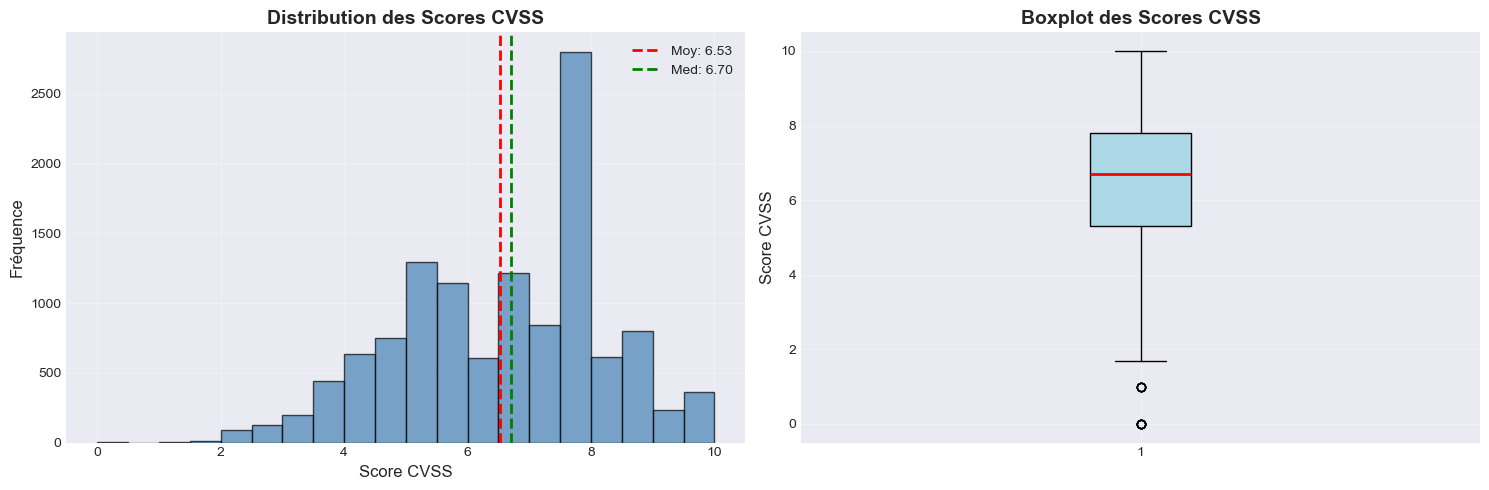

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme
axes[0].hist(df_final['Score CVSS'].dropna(), bins=20, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(df_final['Score CVSS'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moy: {df_final["Score CVSS"].mean():.2f}')
axes[0].axvline(df_final['Score CVSS'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Med: {df_final["Score CVSS"].median():.2f}')
axes[0].set_xlabel('Score CVSS', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution des Scores CVSS', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
bp = axes[1].boxplot(df_final['Score CVSS'].dropna(), vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue'),
                     medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Score CVSS', fontsize=12)
axes[1].set_title('Boxplot des Scores CVSS', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5.3  Répartition par Sévérité


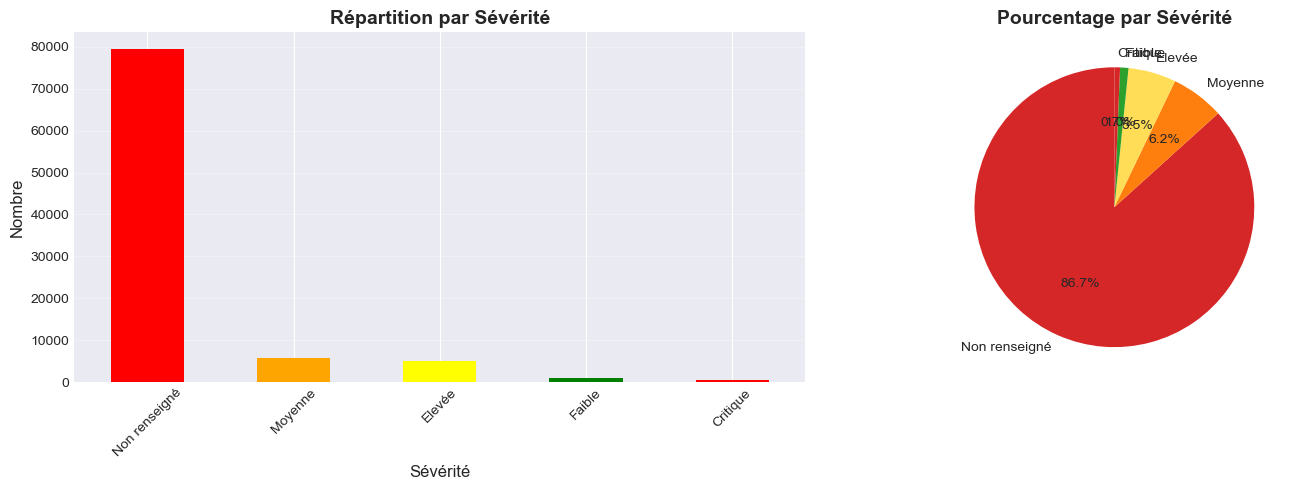

In [67]:
# %%
severity_counts = df_final['Base Severity'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Barres
severity_counts.plot(kind='bar', ax=axes[0], color=['red', 'orange', 'yellow', 'green'])
axes[0].set_xlabel('Sévérité', fontsize=12)
axes[0].set_ylabel('Nombre', fontsize=12)
axes[0].set_title('Répartition par Sévérité', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Camembert
colors = ['#d62728', '#ff7f0e', '#ffdd57', '#2ca02c']
axes[1].pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
axes[1].set_title('Pourcentage par Sévérité', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 5.4  Top 10 Types CWE

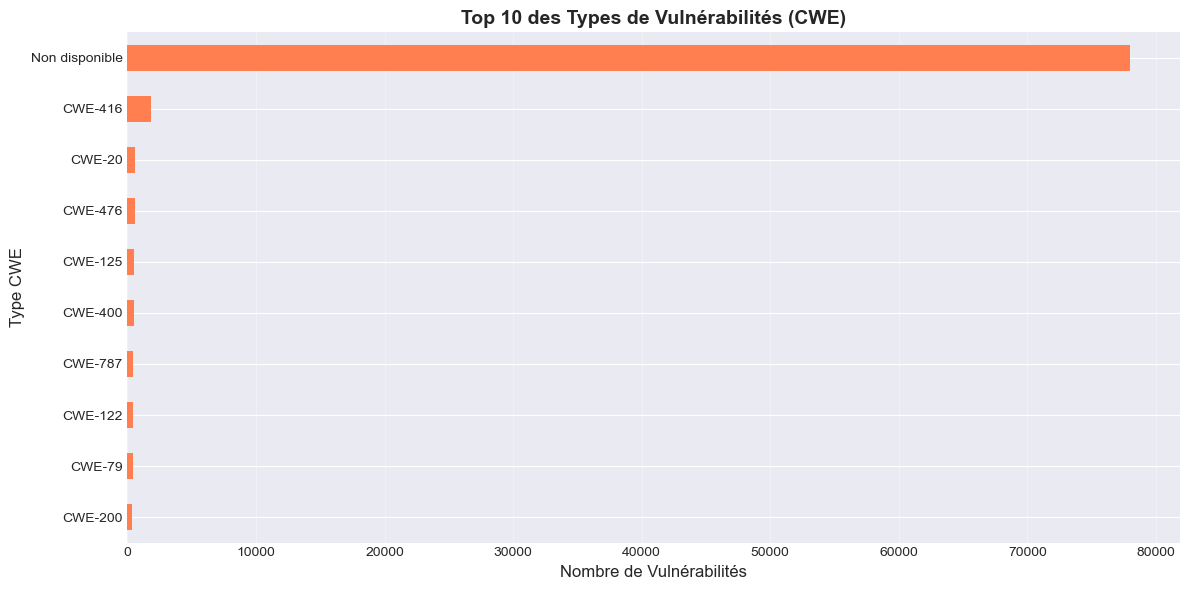

In [68]:
top_cwe = df_final['Type CWE'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_cwe.plot(kind='barh', color='coral')
plt.xlabel('Nombre de Vulnérabilités', fontsize=12)
plt.ylabel('Type CWE', fontsize=12)
plt.title('Top 10 des Types de Vulnérabilités (CWE)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.5 Relation CVSS vs EPSS

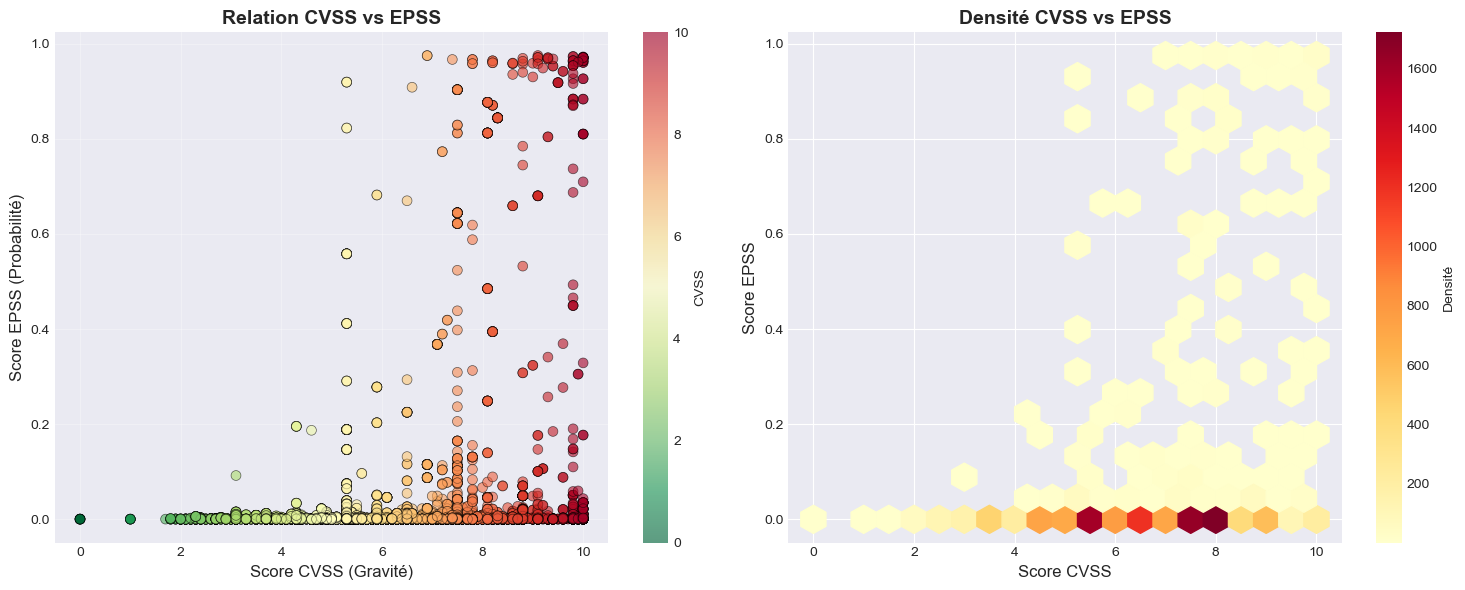

In [73]:
df_valid = df_final.dropna(subset=['Score CVSS', 'Score EPSS'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Nuage de points
scatter = axes[0].scatter(df_valid['Score CVSS'], df_valid['Score EPSS'], 
                          c=df_valid['Score CVSS'], cmap='RdYlGn_r', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Score CVSS (Gravité)', fontsize=12)
axes[0].set_ylabel('Score EPSS (Probabilité)', fontsize=12)
axes[0].set_title('Relation CVSS vs EPSS', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='CVSS')

# Hexbin - stocker l'objet retourné
hexbin = axes[1].hexbin(df_valid['Score CVSS'], df_valid['Score EPSS'], 
                        gridsize=20, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Score CVSS', fontsize=12)
axes[1].set_ylabel('Score EPSS', fontsize=12)
axes[1].set_title('Densité CVSS vs EPSS', fontsize=14, fontweight='bold')
plt.colorbar(hexbin, ax=axes[1], label='Densité')  # ✅ Utiliser l'objet hexbin

plt.tight_layout()
plt.show()

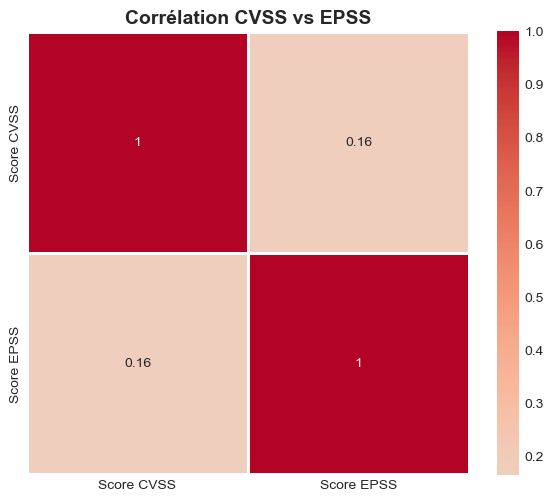

Corrélation : 0.165


In [74]:
# Corrélation
corr = df_final[['Score CVSS', 'Score EPSS']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Corrélation CVSS vs EPSS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print(f"Corrélation : {corr.iloc[0, 1]:.3f}")


## 5.6 Top 10 Éditeurs


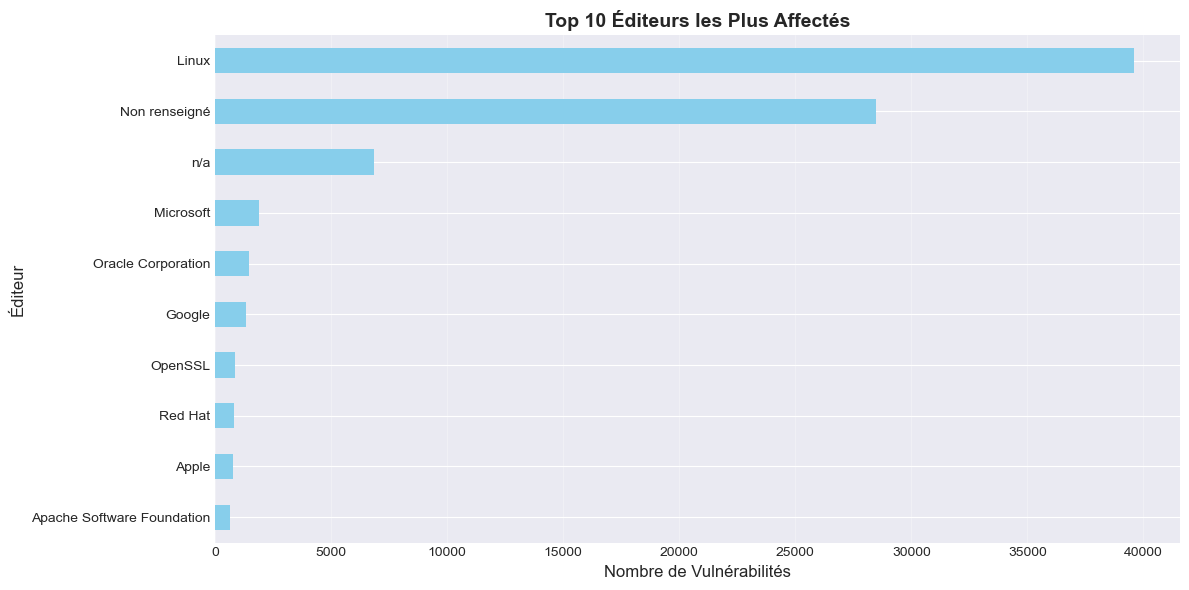

In [75]:
top_vendors = df_final['Editeur/Vendor'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_vendors.plot(kind='barh', color='skyblue')
plt.xlabel('Nombre de Vulnérabilités', fontsize=12)
plt.ylabel('Éditeur', fontsize=12)
plt.title('Top 10 Éditeurs les Plus Affectés', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 5.7 Top 10 Produits

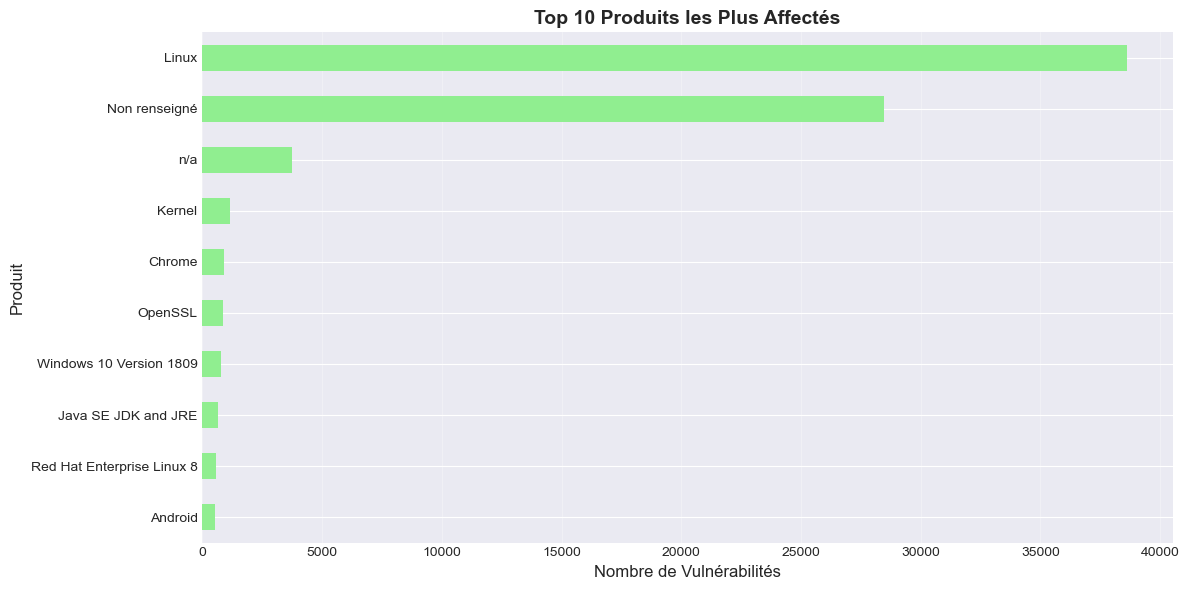

In [76]:
top_products = df_final['Produit'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='barh', color='lightgreen')
plt.xlabel('Nombre de Vulnérabilités', fontsize=12)
plt.ylabel('Produit', fontsize=12)
plt.title('Top 10 Produits les Plus Affectés', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 5.8 Évolution Temporelle

ValueError: zero-size array to reduction operation fmin which has no identity

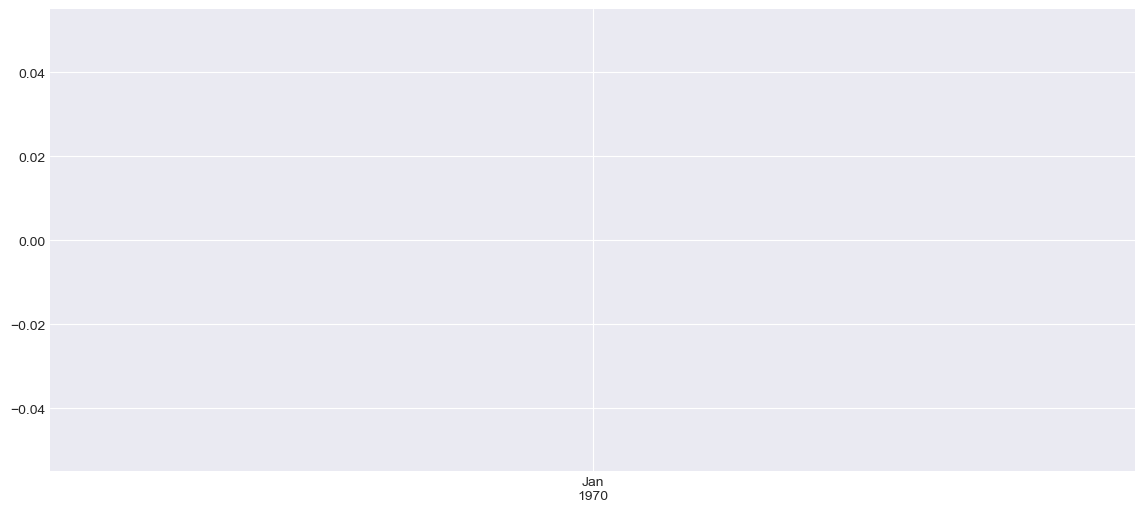

In [77]:
temporal = df_final.groupby('Année-Mois').size()

plt.figure(figsize=(14, 6))
temporal.plot(kind='line', marker='o', linewidth=2, markersize=6, color='purple')
plt.xlabel('Période', fontsize=12)
plt.ylabel('Nombre de Vulnérabilités', fontsize=12)
plt.title('Évolution Temporelle des Vulnérabilités', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5.9 Boxplot CVSS par Éditeur (Top 5)

<Figure size 1200x600 with 0 Axes>

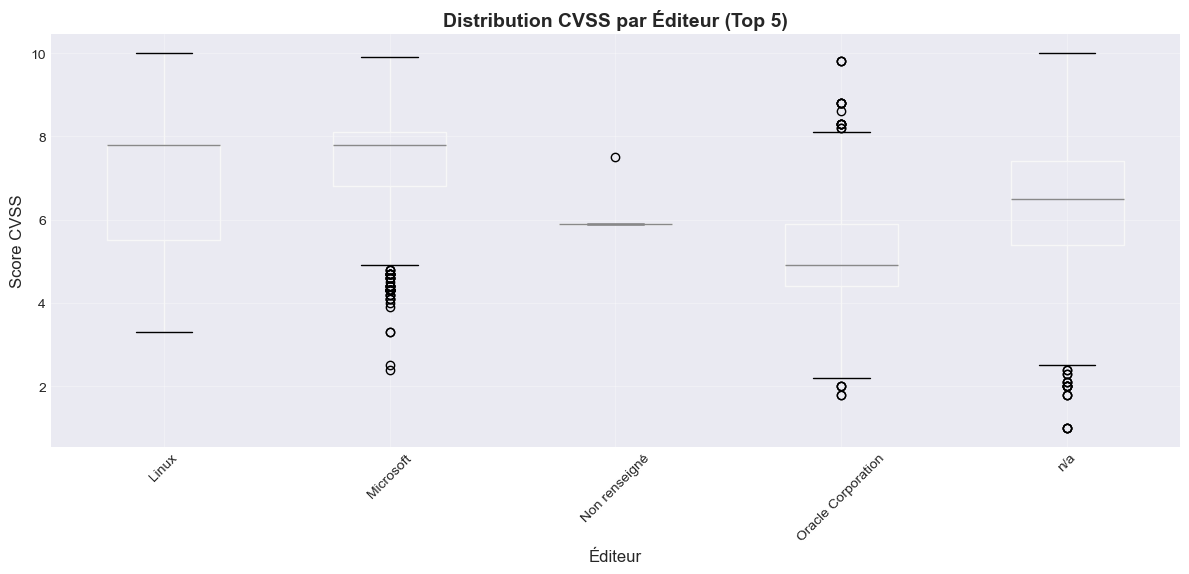

In [78]:
top5_v = df_final['Editeur/Vendor'].value_counts().head(5).index
df_top5 = df_final[df_final['Editeur/Vendor'].isin(top5_v)]

plt.figure(figsize=(12, 6))
df_top5.boxplot(column='Score CVSS', by='Editeur/Vendor', figsize=(12, 6))
plt.xlabel('Éditeur', fontsize=12)
plt.ylabel('Score CVSS', fontsize=12)
plt.title('Distribution CVSS par Éditeur (Top 5)', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5.10 Comparaison Avis vs Alertes

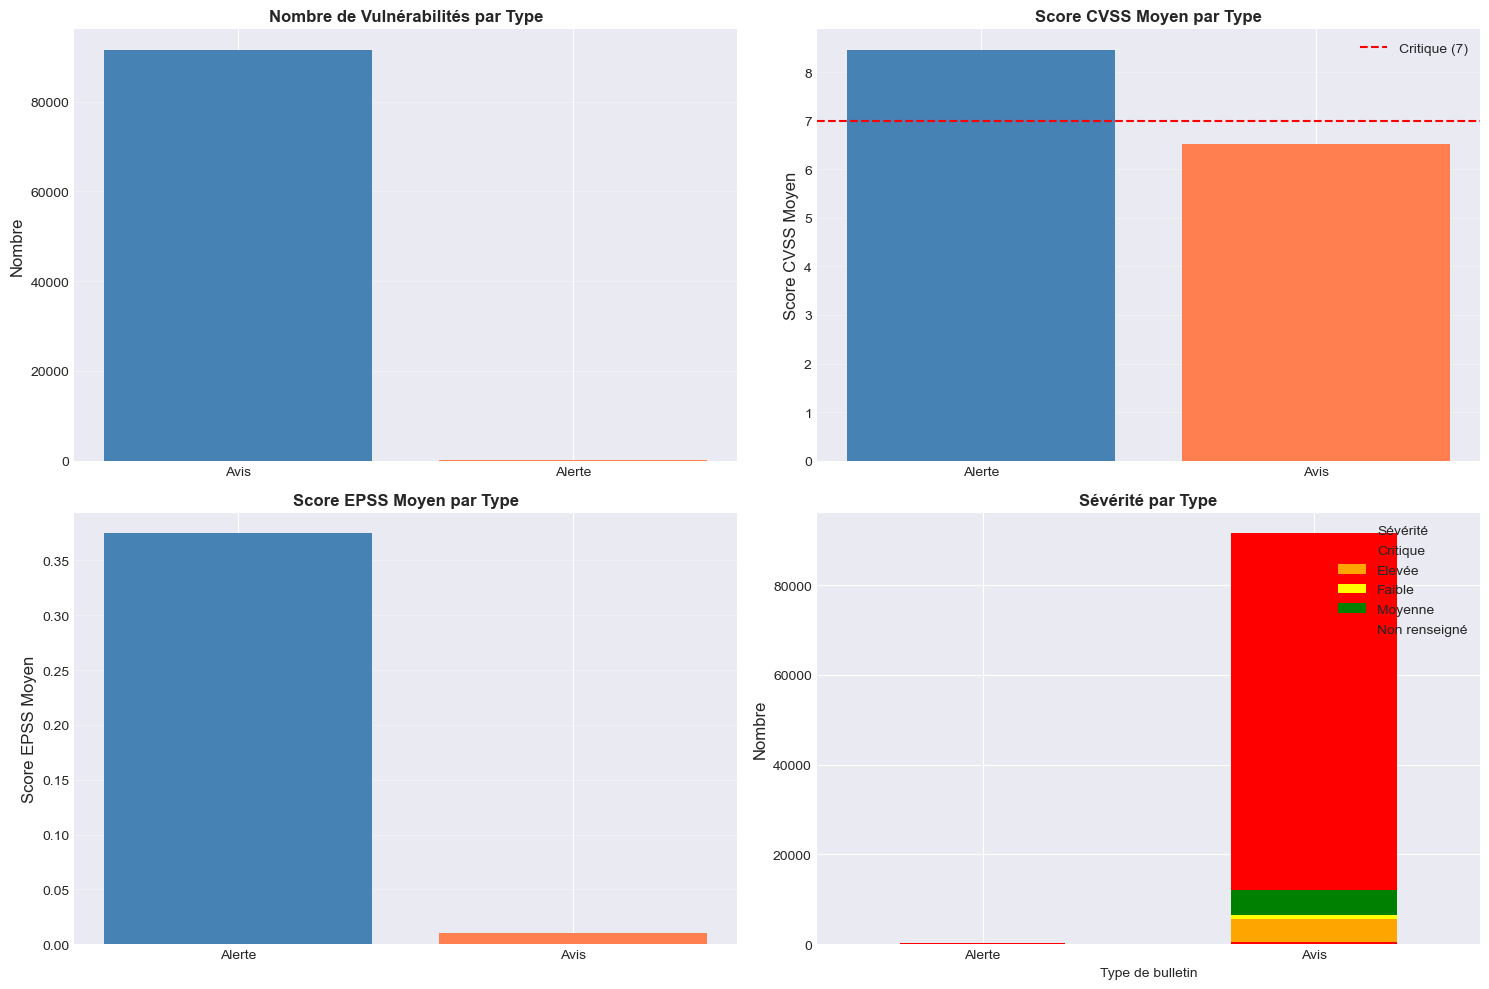

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Nombre
type_counts = df_final['Type de bulletin'].value_counts()
axes[0, 0].bar(type_counts.index, type_counts.values, color=['steelblue', 'coral'])
axes[0, 0].set_ylabel('Nombre', fontsize=12)
axes[0, 0].set_title('Nombre de Vulnérabilités par Type', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# CVSS moyen
cvss_type = df_final.groupby('Type de bulletin')['Score CVSS'].mean()
axes[0, 1].bar(cvss_type.index, cvss_type.values, color=['steelblue', 'coral'])
axes[0, 1].set_ylabel('Score CVSS Moyen', fontsize=12)
axes[0, 1].set_title('Score CVSS Moyen par Type', fontsize=12, fontweight='bold')
axes[0, 1].axhline(7, color='red', linestyle='--', label='Critique (7)')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# EPSS moyen
epss_type = df_final.groupby('Type de bulletin')['Score EPSS'].mean()
axes[1, 0].bar(epss_type.index, epss_type.values, color=['steelblue', 'coral'])
axes[1, 0].set_ylabel('Score EPSS Moyen', fontsize=12)
axes[1, 0].set_title('Score EPSS Moyen par Type', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Sévérité
sev_type = pd.crosstab(df_final['Type de bulletin'], df_final['Base Severity'])
sev_type.plot(kind='bar', stacked=True, ax=axes[1, 1], 
              color=['red', 'orange', 'yellow', 'green'])
axes[1, 1].set_ylabel('Nombre', fontsize=12)
axes[1, 1].set_title('Sévérité par Type', fontsize=12, fontweight='bold')
axes[1, 1].legend(title='Sévérité', loc='upper right')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## 5.11 Vulnérabilités Critiques Prioritaires

VULNÉRABILITÉS CRITIQUES
Critères : CVSS ≥ 8.0 ET EPSS ≥ 0.5
Nombre   : 136

Top 10 :
Identifiant CVE  Score CVSS  Score EPSS                 Produit Base Severity
 CVE-2023-22527        10.0     0.97229  Confluence Data Center      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-46604        10.0     0.97082         Apache ActiveMQ      Critique
 CVE-2023-35078        10.0     0.96922 Endpoint Manager Mobile      Critique
 CVE-2023-35078        10.0     0.96922 Endpoint Manager Mobile      Critique


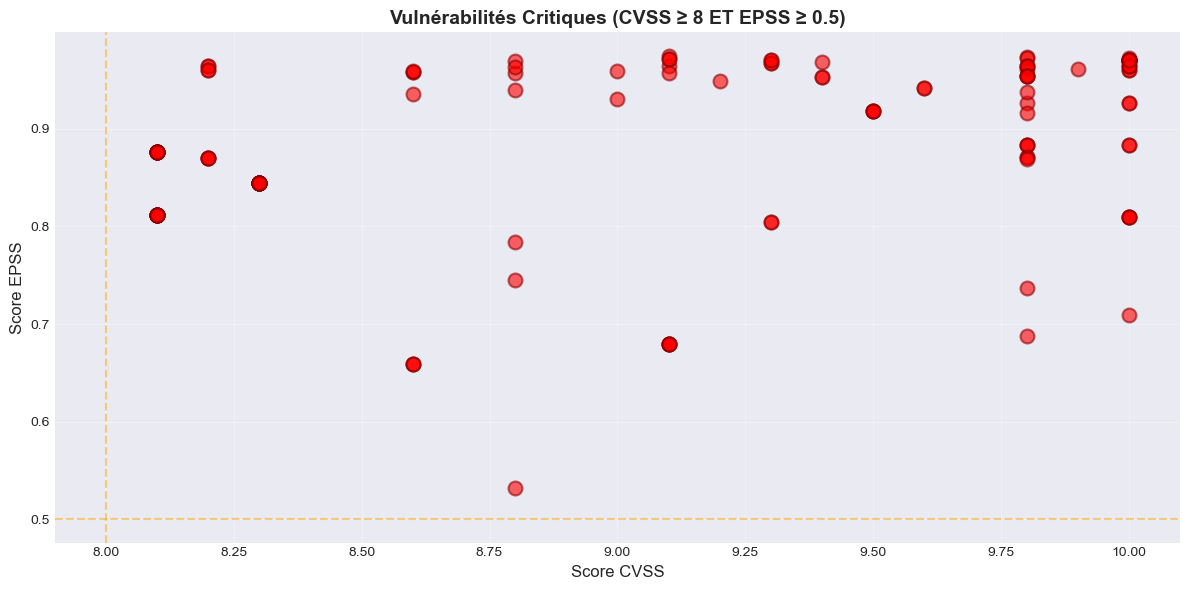

In [81]:
# Critères: CVSS >= 8 ET EPSS >= 0.5
critiques = df_final[(df_final['Score CVSS'] >= 8.0) & (df_final['Score EPSS'] >= 0.5)]

print(f"VULNÉRABILITÉS CRITIQUES")
print("=" * 80)
print(f"Critères : CVSS ≥ 8.0 ET EPSS ≥ 0.5")
print(f"Nombre   : {len(critiques)}")

if len(critiques) > 0:
    crit_sorted = critiques.sort_values(by=['Score CVSS', 'Score EPSS'], ascending=False)
    print("\nTop 10 :")
    print(crit_sorted[['Identifiant CVE', 'Score CVSS', 'Score EPSS', 
                       'Produit', 'Base Severity']].head(10).to_string(index=False))
    
    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.scatter(critiques['Score CVSS'], critiques['Score EPSS'], 
                s=100, c='red', alpha=0.6, edgecolors='darkred', linewidth=1.5)
    plt.xlabel('Score CVSS', fontsize=12)
    plt.ylabel('Score EPSS', fontsize=12)
    plt.title('Vulnérabilités Critiques (CVSS ≥ 8 ET EPSS ≥ 0.5)', 
              fontsize=14, fontweight='bold')
    plt.axhline(0.5, color='orange', linestyle='--', alpha=0.5)
    plt.axvline(8.0, color='orange', linestyle='--', alpha=0.5)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 5.12 Analyse par Année


📅 STATS PAR ANNÉE
Empty DataFrame
Columns: [Nb CVE, CVSS Moy, EPSS Moy]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

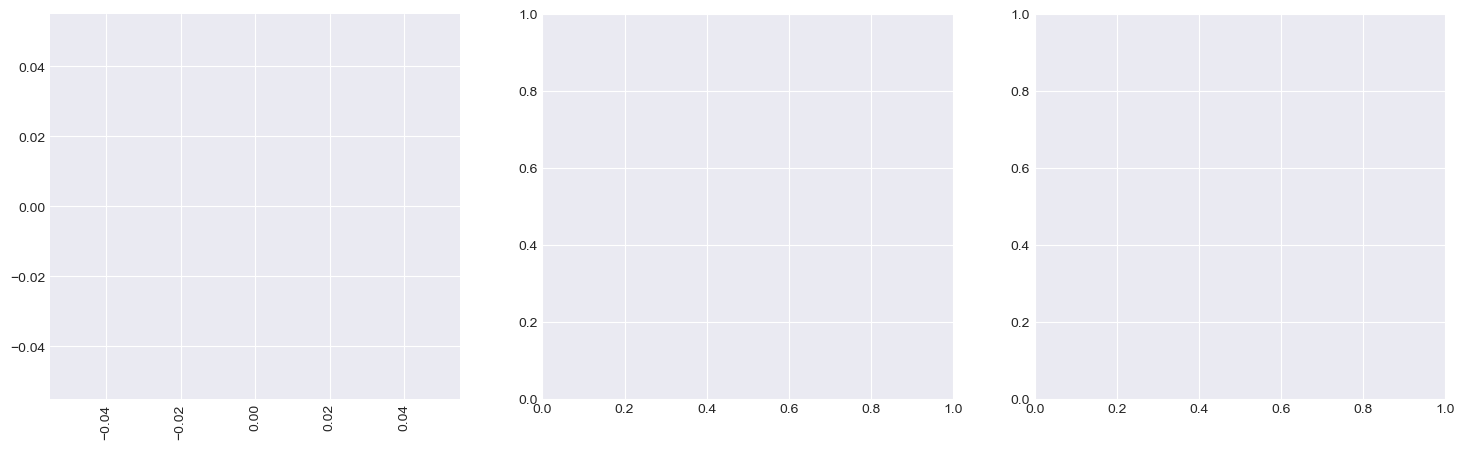

In [82]:
yearly = df_final.groupby('Année').agg({
    'Identifiant CVE': 'count',
    'Score CVSS': 'mean',
    'Score EPSS': 'mean'
}).round(2)
yearly.columns = ['Nb CVE', 'CVSS Moy', 'EPSS Moy']

print("\n📅 STATS PAR ANNÉE")
print(yearly)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Nombre CVE
yearly['Nb CVE'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Année', fontsize=12)
axes[0].set_ylabel('Nombre CVE', fontsize=12)
axes[0].set_title('Nombre CVE par Année', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# CVSS moyen
yearly['CVSS Moy'].plot(kind='line', marker='o', ax=axes[1], color='red', linewidth=2)
axes[1].set_xlabel('Année', fontsize=12)
axes[1].set_ylabel('CVSS Moyen', fontsize=12)
axes[1].set_title('Évolution CVSS Moyen', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

# EPSS moyen
yearly['EPSS Moy'].plot(kind='line', marker='s', ax=axes[2], color='purple', linewidth=2)
axes[2].set_xlabel('Année', fontsize=12)
axes[2].set_ylabel('EPSS Moyen', fontsize=12)
axes[2].set_title('Évolution EPSS Moyen', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 6️. GÉNÉRATION D'ALERTES

## 6.1 Système de Filtrage

In [87]:
def generer_alertes(df, cvss_min=7.0, epss_min=0.3, produits=None, severite=None):
    """
    Filtre les vulnérabilités selon des critères
    
    Args:
        df: DataFrame
        cvss_min: Score CVSS minimum
        epss_min: Score EPSS minimum
        produits: Liste produits (optionnel)
        severite: Liste sévérités (optionnel)
    
    Returns:
        DataFrame filtré
    """
    print(f"\n🔍 CRITÈRES D'ALERTE")
    print(f"  CVSS ≥ {cvss_min}")
    print(f"  EPSS ≥ {epss_min}")
    
    mask = (df['Score CVSS'] >= cvss_min) & (df['Score EPSS'] >= epss_min)
    
    if severite:
        mask &= df['Base Severity'].isin(severite)
        print(f"  Sévérité : {', '.join(severite)}")
    
    if produits:
        mask &= df['Produit'].str.contains('|'.join(produits), case=False, na=False)
        print(f"  Produits : {', '.join(produits)}")
    
    alertes = df[mask].copy()
    print(f"\n✅ {len(alertes)} vulnérabilités")
    
    return alertes


In [88]:
# Exemple d'alertes
alertes = generer_alertes(
    df_final,
    cvss_min=8.0,
    epss_min=0.5,
    severite=['Critique', 'Elevée']
)



🔍 CRITÈRES D'ALERTE
  CVSS ≥ 8.0
  EPSS ≥ 0.5
  Sévérité : Critique, Elevée

✅ 136 vulnérabilités


In [89]:
# Afficher le rapport
if len(alertes) > 0:
    print("\n" + "=" * 80)
    print("RAPPORT D'ALERTES")
    print("=" * 80)
    
    alertes_sorted = alertes.sort_values(by=['Score CVSS', 'Score EPSS'], ascending=False)
    
    for i, (idx, row) in enumerate(alertes_sorted.head(5).iterrows(), 1):
        print(f"\n ALERTE #{i}")
        print(f"   CVE         : {row['Identifiant CVE']}")
        print(f"   Sévérité    : {row['Base Severity']}")
        print(f"   CVSS        : {row['Score CVSS']}")
        print(f"   EPSS        : {row['Score EPSS']:.4f}")
        print(f"   Produit     : {row['Produit']}")
        print(f"   Éditeur     : {row['Editeur/Vendor']}")
        print(f"   Type CWE    : {row['Type CWE']}")
        print(f"   Bulletin    : {row['Type de bulletin']}")
        print(f"   Lien        : {row['Lien du bulletin (ANSSI)']}")
        print("-" * 80)
    
    # Export
    alertes_file = OUTPUT_DIR / "alertes_critiques.csv"
    alertes.to_csv(alertes_file, index=False, encoding='utf-8')
    print(f"\n Alertes sauvegardées : {alertes_file}")



RAPPORT D'ALERTES

 ALERTE #1
   CVE         : CVE-2023-22527
   Sévérité    : Critique
   CVSS        : 10.0
   EPSS        : 0.9723
   Produit     : Confluence Data Center
   Éditeur     : Atlassian
   Type CWE    : Non disponible
   Bulletin    : Avis
   Lien        : 
--------------------------------------------------------------------------------

 ALERTE #2
   CVE         : CVE-2023-46604
   Sévérité    : Critique
   CVSS        : 10.0
   EPSS        : 0.9708
   Produit     : Apache ActiveMQ
   Éditeur     : Apache Software Foundation
   Type CWE    : CWE-502
   Bulletin    : Avis
   Lien        : 
--------------------------------------------------------------------------------

 ALERTE #3
   CVE         : CVE-2023-46604
   Sévérité    : Critique
   CVSS        : 10.0
   EPSS        : 0.9708
   Produit     : Apache ActiveMQ
   Éditeur     : Apache Software Foundation
   Type CWE    : CWE-502
   Bulletin    : Avis
   Lien        : 
------------------------------------------------

## 6.2 Template Email HTML

In [92]:
def generer_email_html(alertes_df, destinataire="Équipe Sécurité"):
    """Génère le contenu HTML pour email d'alerte"""
    
    total = len(alertes_df)
    critiques = (alertes_df['Base Severity'] == 'Critique').sum()
    elevees = (alertes_df['Base Severity'] == 'Elevée').sum()
    
    top5 = alertes_df.sort_values(by=['Score CVSS', 'Score EPSS'], ascending=False).head(5)
    
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <style>
            body {{ font-family: Arial, sans-serif; }}
            .header {{ background-color: #d32f2f; color: white; padding: 20px; text-align: center; }}
            .stats {{ background-color: #f5f5f5; padding: 15px; margin: 20px 0; }}
            .alert-box {{ border-left: 4px solid #d32f2f; padding: 15px; margin: 15px 0; background-color: #fff3f3; }}
            table {{ width: 100%; border-collapse: collapse; }}
            th, td {{ padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1> Alerte Sécurité ANSSI</h1>
        </div>
        
        <p>Bonjour {destinataire},</p>
        
        <div class="stats">
            <h3> Résumé</h3>
            <p><strong>Total:</strong> {total} | <strong>Critiques:</strong> {critiques} | <strong>Élevées:</strong> {elevees}</p>
            <p><strong>Date:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M')}</p>
        </div>
        
        <h3> Top 5 Vulnérabilités</h3>
    """
    
    for _, row in top5.iterrows():
        html += f"""
        <div class="alert-box">
            <h4>{row['Identifiant CVE']}</h4>
            <table>
                <tr><th>Sévérité</th><td>{row['Base Severity']}</td></tr>
                <tr><th>CVSS</th><td>{row['Score CVSS']}</td></tr>
                <tr><th>EPSS</th><td>{row['Score EPSS']:.4f}</td></tr>
                <tr><th>Produit</th><td>{row['Produit']}</td></tr>
                <tr><th>Éditeur</th><td>{row['Editeur/Vendor']}</td></tr>
                <tr><th>CWE</th><td>{row['Type CWE']}</td></tr>
            </table>
        </div>
        """
    
    html += """
        <h3> Actions Recommandées</h3>
        <ul>
            <li>Vérifier si vos systèmes sont affectés</li>
            <li>Appliquer les correctifs dès que possible</li>
            <li>Consulter les bulletins ANSSI</li>
        </ul>
    </body>
    </html>
    """
    
    return html

In [93]:
# Générer email (exemple)
if len(alertes) > 0:
    html_email = generer_email_html(alertes)
    
    # Sauvegarder le template
    email_file = OUTPUT_DIR / "alerte_email.html"
    with open(email_file, 'w', encoding='utf-8') as f:
        f.write(html_email)
    
    print(f" Template email sauvegardé : {email_file}")


 Template email sauvegardé : output\alerte_email.html


# 7️. CONCLUSIONS

In [96]:
print("\n" + "=" * 80)
print("CONCLUSIONS")
print("=" * 80)

print(f"\n1. Volume")
print(f"   - {df_final['Identifiant CVE'].nunique()} CVE uniques")
print(f"   - {df_final['Titre du bulletin (ANSSI)'].nunique()} bulletins")

crit_pct = (df_final['Base Severity'] == 'Critique').sum() / len(df_final) * 100
print(f"\n2. Sévérité")
print(f"   - {crit_pct:.1f}% critiques")
print(f"   - Score CVSS moyen : {df_final['Score CVSS'].mean():.2f}")

high_epss = (df_final['Score EPSS'] >= 0.5).sum()
print(f"\n3. Exploitation")
print(f"   - {high_epss} vulnérabilités EPSS ≥ 0.5")
print(f"   - Score EPSS moyen : {df_final['Score EPSS'].mean():.4f}")

top3_v = df_final['Editeur/Vendor'].value_counts().head(3)
print(f"\n4. Top 3 Éditeurs à Risque")
for i, (v, cnt) in enumerate(top3_v.items(), 1):
    print(f"   {i}. {v}: {cnt} vulnérabilités")

top_cwe_main = df_final['Type CWE'].value_counts().head(1)
print(f"\n5. CWE Principal")
print(f"   - {top_cwe_main.index[0]}: {top_cwe_main.values[0]} occurrences")

print("\n" + "=" * 80)
print("ANALYSE TERMINÉE")
print("=" * 80)



CONCLUSIONS

1. Volume
   - 29940 CVE uniques
   - 810 bulletins

2. Sévérité
   - 0.7% critiques
   - Score CVSS moyen : 6.53

3. Exploitation
   - 729 vulnérabilités EPSS ≥ 0.5
   - Score EPSS moyen : 0.0111

4. Top 3 Éditeurs à Risque
   1. Linux: 39598 vulnérabilités
   2. Non renseigné: 28464 vulnérabilités
   3. n/a: 6850 vulnérabilités

5. CWE Principal
   - Non disponible: 77967 occurrences

ANALYSE TERMINÉE
